In [35]:

import gridworlds           # import to trigger registration of the environment
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# create instance
env = gym.make("gridworld-v0",start_state=np.array([2,2]))
env.reset()

(array([2, 2]), {})

In [36]:
class Policy:
    def __init__(self,size=5,initial_policy=None,eps_soft=0.4,gamma=0.9,importance_sampling=True):
        self.importance_sampling=importance_sampling
        self.gamma=gamma
        self.size=size
        self.eps_soft=eps_soft
        if initial_policy ==None:
           self.beh_policy=np.full((self.size**2,4),0.25)
           self.tar_policy=np.full((self.size**2,4),0.25)
     
        else:
            self.beh_policy=initial_policy
            self.tar_policy=np.full((self.size**2,4),0.25)
       
        self.N_detailed=np.zeros((self.size**2,4,self.size**2))
        self.N_first_vistis=np.zeros((self.size**2,4))
        self.Q=np.zeros((self.size**2,4))
        self.C=np.zeros((self.size**2,4))
        self.v=np.zeros((self.size**2))
        self.Rewards_cum=np.zeros((self.size**2,4))
        self.pos_dict={i*self.size+j: [i,j] for i in range(self.size) for j in range(self.size)}
        self.action_dict={0:"up",1:'right',2:"down",3:"left" }

    def state_translate(self,state):
        return state[0]*self.size+state[1]
    def act_behaviour(self, state):
        return np.random.choice(4, p=self.beh_policy[state])
    
    def act_target(self, state):
        return np.random.choice(4, p=self.target_policy[state])
    
    def eval_episode(self,episode):
        G=0
        W=1
        first_oc=np.empty_like(self.Q)
        first_oc[:] = np.nan
        for i, values in enumerate(episode):
            state, action, reward = values
            state=int(state)
            action=int(action)
            if np.isnan(first_oc[state,action]):
                first_oc[state,action]=i

        for i, step in reversed(list(enumerate(episode))):
            
            state, action, reward=step
            state=int(state)
            action=int(action)
            G=self.gamma*G + reward
            W*=self.tar_policy[state,action]/self.beh_policy[state,action]
            self.N_detailed[state,action,state]+=1
            W=1
            if first_oc[state, action]==i:
                if self.importance_sampling:
                    self.C[state,action]+=W
                    self.Q[state,action]+=W/self.C[state,action]*(G-self.Q[state,action])
                else:
                    self.N_first_vistis[state,action]+=1
                    self.Q[state,action]=(self.Q[state,action]*(self.N_first_vistis[state,action]-1)+G)/self.N_first_vistis[state,action]



                

    def improve_policy(self):
        for state in range(self.Q.shape[0]):
            best_action_value=np.max(self.Q[state])
            best_actions_am=0
            new_probs_tar=np.zeros(4)
            
            for i, action_value in enumerate(self.Q[state]):
                if action_value== best_action_value:
                    new_probs_tar[i]=1
                    best_actions_am+=1    
            new_probs_tar=new_probs_tar/best_actions_am
            new_probs_beh=new_probs_tar*(1-self.eps_soft)+np.full(4,self.eps_soft/4)
            self.beh_policy[state]=new_probs_beh
            self.tar_policy[state]=new_probs_tar

        self.Returns=[[] for i in range(self.size**2)]

    def v_mat(self):
        self.v=np.sum(self.Q, axis=1)/4
        V_mat=np.zeros((self.size,self.size))
        for i, val in enumerate(self.v):
            in_1, in_2=self.pos_dict[i]
            V_mat[in_1,in_2]=val
        return V_mat
    
    
    def policy_mat(self,pol_id="beh"):
        if pol_id=="beh":
            pi_mat=np.zeros((self.size,self.size,4))
            for i  in range(self.beh_policy.shape[0]):
                in_1, in_2=self.pos_dict[i]
                pi_mat[in_1,in_2]=self.beh_policy[i]
        else:
            pi_mat=np.zeros((self.size,self.size,4))
            for i  in range(self.tar_policy.shape[0]):
                in_1, in_2=self.pos_dict[i]
                pi_mat[in_1,in_2]=self.tar_policy[i]
        return pi_mat
       
    def show_heatmap(self,it_nr):
        fig, ax = plt.subplots()
        V_mat=self.v_mat()
        im = ax.imshow(V_mat, cmap='viridis')

        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(self.size))
        ax.set_yticks(np.arange(self.size))

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(self.size):
            for j in range(self.size):
                text = ax.text(j, i, round(V_mat[i, j], 2),
                            ha="center", va="center", color="w")

        ax.set_title(f"State value function heatmap it={it_nr}")
        fig.tight_layout()
        plt.show()

    def show_action_value_heatmap(self,it_nr):
        fig, axs = plt.subplots(2, 2, figsize=(10, 8))  
        Square_Q=np.reshape(self.Q,(self.size,self.size,4))
        
        for key, action in self.action_dict.items():
                
                i=key//2
                j=key%2

                ax = axs[i, j] 
                im = ax.imshow(Square_Q[:,:,key], cmap='viridis')  

                # Show all ticks and label them with the respective list entries
                ax.set_xticks(np.arange(self.size))
                ax.set_yticks(np.arange(self.size))

                # Rotate the tick labels and set their alignment
                plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

                # Loop over data dimensions and create text annotations
                for x in range(self.size):
                    for y in range(self.size):
                        text = ax.text(y, x, round(Square_Q[x,y,key], 2),
                                       ha="center", va="center", color="w")

  
                ax.set_title(f'Action value heatmap for action "{action}" and it={it_nr}')
        
        fig.tight_layout()
        
    
        plt.show()
    
    def show_policy(self,it_nr,pol_id="tar"):

        Pi_mat=self.policy_mat(pol_id)
        V_mat=self.v_mat()
        policy_arrows_direction = {0: (0,-1), 1: (1,0), 2:(0,1) , 3:(-1,0) }
       

        

        fig, ax = plt.subplots()
        ax.imshow(V_mat, cmap='viridis')

        # Show all ticks and label them with the respective list entries
        ax.set_xticks(np.arange(self.size))
        ax.set_yticks(np.arange(self.size))

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        for i in range(self.size):
            for j in range(self.size):
                best_action_prob = np.max(Pi_mat[i, j])
                for k, action_prob in enumerate(Pi_mat[i, j]):
                    if action_prob==best_action_prob:
                        direction = policy_arrows_direction[k]

                        # Calculate the position for the arrow (center of each cell)
                        x, y = j, i

                        # Add the arrow to the plot
                        arrow_kwargs={'color':"w", "length_includes_head":True,"head_width":0.03}
                        ax.arrow(x, y, direction[0] * 0.2, direction[1] * 0.2,**arrow_kwargs)
        if pol_id=="beh":
            policy_name="behaviour"
        else:
            policy_name="target"
        ax.set_title(f"Gridworld {policy_name} Policy it={it_nr}")
        fig.tight_layout()
        plt.show()
        
    
    def optimise(self,env,max_iterations, eps_per_iter=1,max_eps_length=50,plot=True):
        if plot and eps_per_iter==1:
            reward_sums=[0]*max_iterations
        for it in range(max_iterations):
            for eps_nr in range(eps_per_iter):
                env.reset()
                state, _ =env.reset()
                episode=[]  
                old_state=state
                for i in range(max_eps_length):
                    action = self.act_behaviour(self.state_translate(state))
                    state, reward, terminated, truncated, _ = env.step(action) 
                    episode.append([self.state_translate(old_state),action,reward])
                    old_state=state
                    if terminated or truncated:
                        break
                episode=np.array(episode)
                self.eval_episode(episode)
            if plot and eps_per_iter==1:
                reward_sums[it]=sum(episode[:,2])
            self.improve_policy()
        if plot:
            self.show_action_value_heatmap(it)
            self.show_policy(it)   
            if eps_per_iter==1:
                plt.plot(range(0,max_iterations),reward_sums)
                plt.title("Accumulutated sums per Episode")
                plt.xlabel("Episodes")
                plt.ylabel("Accumulated Reward")
                plt.show()
    
    

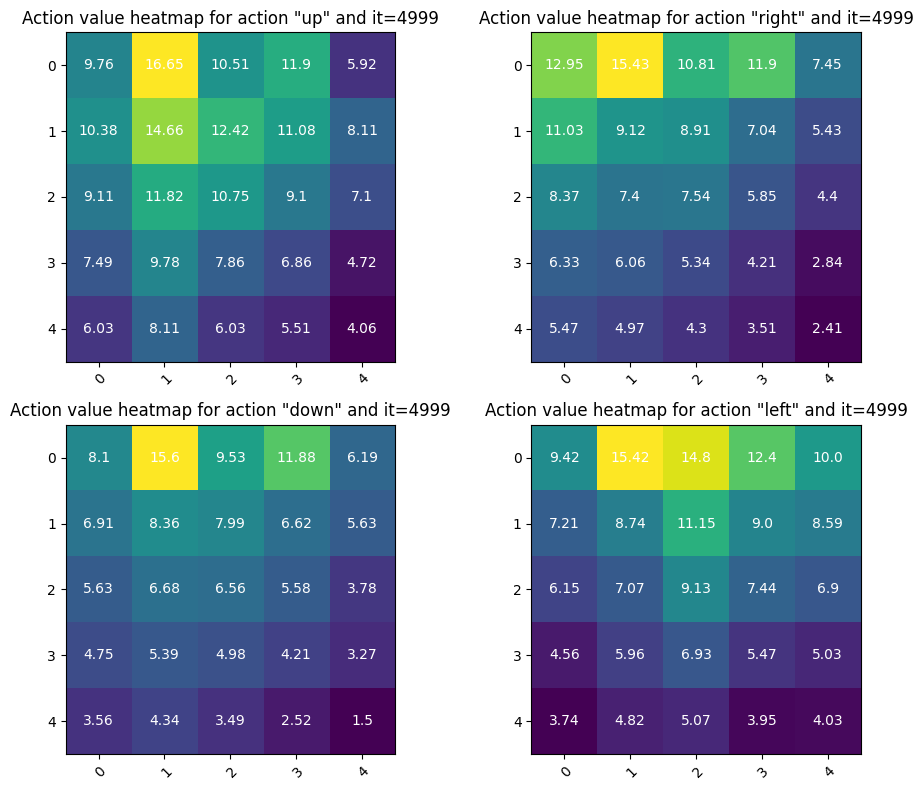

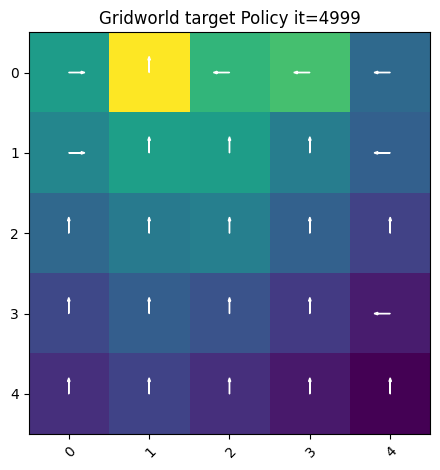

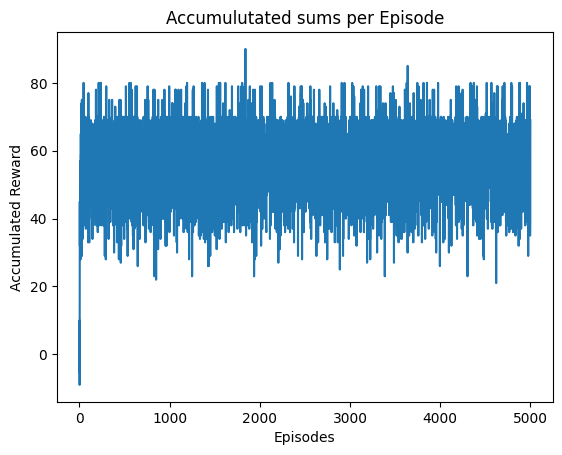

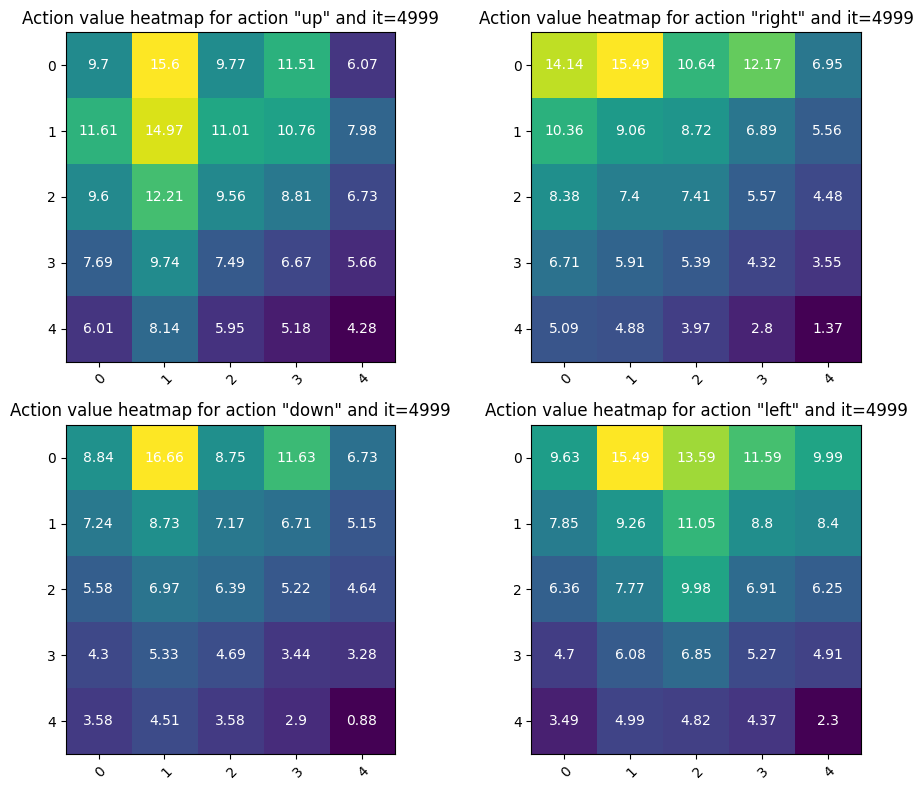

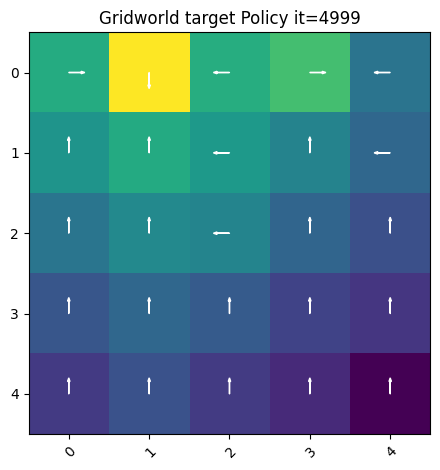

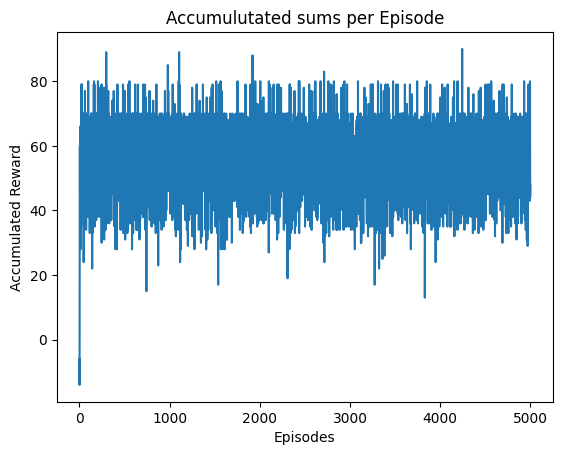

In [37]:

policy_imp=Policy()
policy_imp.optimise(env,5000,eps_per_iter=1)
policy_wo_imp=Policy(importance_sampling=False)
policy_wo_imp.optimise(env,5000,eps_per_iter=1)

In [38]:
print(policy_wo_imp.Q[0])
print(policy_wo_imp.Q[5])
a=policy_imp.Q
print(a[0])
a=np.reshape(a,(5,5,4))
print(a[0,0])

[ 9.69636986 14.14339217  8.83548442  9.63447849]
[11.61459575 10.35975593  7.23704957  7.84622271]
[ 9.76042067 12.94932143  8.10341769  9.41883502]
[ 9.76042067 12.94932143  8.10341769  9.41883502]
